# **Machine Learning - Ajust Model**

## Objectiu

Selecció dels paràmeres que proporcionen un millor rendiment per al model més prometedor: CatBoost.

Mitjançant selecció de variables, rangs d'edat i hiperparàmetres que optimitzin el rendiment del model



## **PAS1: importar llibreries**

In [ ]:
!pip install catboost
!pip install optuna

In [ ]:
# importar llibreries
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score


import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os


## **PAS2: enllaçar amb drive**

In [ ]:
#paths relatius a l'arxiu ipynb
from google.colab import drive
import glob
# recuperar ruta de l0scritp
script_name = '5_Analysis_ML.ipynb'
drive.mount(os.getcwd() + '/drive')
script_path = glob.glob(os.getcwd() + '/**/' + script_name, recursive = True)
print(script_path)
head_tail = os.path.split(script_path[0])
# guardem carpeta de treball
work_path = head_tail[0];


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content/drive/MyDrive/TFM/Finals/5_Analysis_ML.ipynb']


## **PAS3: llegir arxius**

In [ ]:
#llegir CSV
v_path = work_path + '/CSV/harmonized_data.csv'
# Lectura arxiu
vol = pd.read_csv(v_path, encoding='latin-1')

In [ ]:
print("El conjunt de dades conté informació de " + str(vol.shape[0]) + " persones diferents i " + str(vol.shape[1]) + " variables.")

El conjunt de dades conté informació de 316 persones diferents i 39 variables.


Agafar les dades dels individus de 10 a 32 anys


In [ ]:
# el rang amb millor rendiment és aquell amb els subjectes compresos en el rang d'edats de 10 a 32 anys
vol = vol[vol['AGE_AT_SCAN'].between(10, 32)].copy().reset_index(drop=True)

In [ ]:
print("El conjunt de dades conté informació de " + str(vol.shape[0]) + " persones diferents i " + str(vol.shape[1]) + " variables.")

El conjunt de dades conté informació de 294 persones diferents i 39 variables.


## PAS4: Preparació de les Dades

Eliminar columnes unnamed, SITE, SUB_ID i FIQ

In [ ]:
# data frame
vol.drop(vol.columns[vol.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
# eliminar paràmetres
vol.drop(['SITE','SUB_ID','FIQ'], axis=1, inplace=True)
vol.columns

Index(['left cerebral white matter', 'left cerebral cortex',
       'left lateral ventricle', 'left inferior lateral ventricle',
       'left cerebellum white matter', 'left cerebellum cortex',
       'left thalamus', 'left caudate', 'left putamen', 'left pallidum',
       '3rd ventricle', '4th ventricle', 'brain-stem', 'left hippocampus',
       'left amygdala', 'csf', 'left accumbens area', 'left ventral DC',
       'right cerebral white matter', 'right cerebral cortex',
       'right lateral ventricle', 'right inferior lateral ventricle',
       'right cerebellum white matter', 'right cerebellum cortex',
       'right thalamus', 'right caudate', 'right putamen', 'right pallidum',
       'right hippocampus', 'right amygdala', 'right accumbens area',
       'right ventral DC', 'DX_GROUP', 'AGE_AT_SCAN', 'SEX'],
      dtype='object')

In [ ]:
# copio les dades en un dataset de treball
df_to_test = vol.copy(True)

x = df_to_test.drop(['DX_GROUP'], axis=1)
y = df_to_test['DX_GROUP'].astype('category')

### Visualitzar importància dels diferents *features* amb RandomForest

3rd ventricle                       0.060244
right cerebral white matter         0.047193
AGE_AT_SCAN                         0.045734
left caudate                        0.039959
right pallidum                      0.035218
right accumbens area                0.035143
left cerebral white matter          0.034308
brain-stem                          0.034075
csf                                 0.032420
left putamen                        0.031188
right caudate                       0.030798
left hippocampus                    0.030345
right thalamus                      0.029632
left amygdala                       0.029458
left ventral DC                     0.029183
left cerebellum cortex              0.028718
right ventral DC                    0.028662
left pallidum                       0.028337
4th ventricle                       0.027018
left lateral ventricle              0.027004
right lateral ventricle             0.025902
left thalamus                       0.025771
left infer

/tmp/ipython-input-3405175868.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(importances,palette='Spectral')


Text(0.5, 1.0, 'Importància regions')

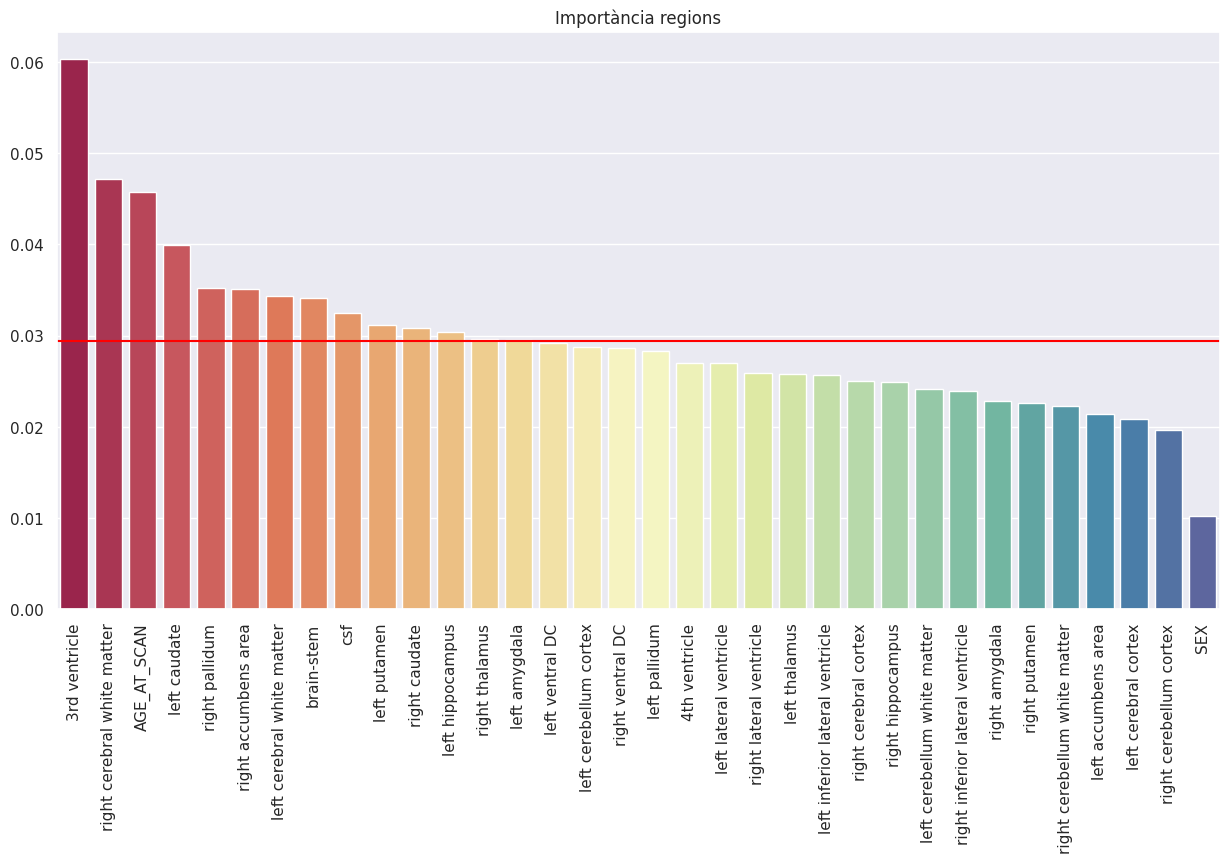

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Entrenar Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Importància de les regions
importances = pd.Series(rf.feature_importances_, index=x.columns).sort_values(ascending=False)
top10 = importances
print(top10)

fig, axis = plt.subplots(figsize = (15,7.5))
plot = sns.barplot(importances,palette='Spectral')
plot.axhline(importances.mean(), color='red')
plot.set_xticks(np.arange(len(importances)))
plot.set_xticklabels(plot.get_xticklabels(),rotation = 90)
plot.set_title("Importància regions")

In [ ]:
# seleccionar les regions que tenen una importància >= mitjana
mean_val = importances.mean()
median_val = importances.median()
# filtre de variables
regions_select = importances[importances > mean_val + 0.003].index
print(regions_select)

Index(['3rd ventricle', 'right cerebral white matter', 'AGE_AT_SCAN',
       'left caudate', 'right pallidum', 'right accumbens area',
       'left cerebral white matter', 'brain-stem', 'csf'],
      dtype='object')


In [ ]:
# reduir dataset a variables amb més importància
# el millor model és aquell que fa servir totes les variables
#x = x[regions_select]

In [ ]:
print("x shape: " + str(x.shape))
print("y shape: " + str(y.shape))

x shape: (294, 34)
y shape: (294,)


In [ ]:
freq_table = pd.crosstab(y, "Distribució subjectes")
freq_table

col_0,Distribució subjectes
DX_GROUP,
CONTROL,145
TEA,149


### Escalat de les dades

In [ ]:
scaler = StandardScaler().set_output(transform="pandas")
x_scaled = scaler.fit_transform(x)

### Dividir conjunts d'entrenament i test

In [ ]:
seed = 2025
test_size = 0.2
train_size = 0.8
msg = "Per separar les dades d'entrenament i test es fa servir la llavor = " +  str(seed) + ", un " + str(train_size*100) +  "% de les dades per a l'entrenament i un " + str(test_size*100) + "% per a la verificació"
print(msg)
# separació de les dades d'entrenament i test
xtrain, xtest, ytrain, ytest = train_test_split(x_scaled, y, test_size=test_size, random_state=seed)

Per separar les dades d'entrenament i test es fa servir la llavor = 2025, un 80.0% de les dades per a l'entrenament i un 20.0% per a la verificació


Estructura de les dades:

In [ ]:
print('xtrain shape: ', xtrain.shape)
print('ytrain shape: ', ytrain.shape)
print('xtest shape: ', xtest.shape)
print('ytest shape: ', ytest.shape)

xtrain shape:  (235, 34)
ytrain shape:  (235,)
xtest shape:  (59, 34)
ytest shape:  (59,)


In [ ]:
# convertir categories a números (TEA a 0 i CONTROL a 1)
ytrain_np = ytrain.map({"TEA": 0, "CONTROL": 1}).to_numpy()
ytest_np = ytest.map({"TEA": 0, "CONTROL": 1}).to_numpy()

## PAS5: CatBoost



### Cerca dels millors hiperparàmetres

In [ ]:
import optuna

# Funció objectiu per Optuna
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 200, 2000),
        "depth": trial.suggest_int("depth", 6,10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
        "loss_function": "Logloss",
        "eval_metric": "Accuracy",
        "verbose": False,
    }

    model = CatBoostClassifier(**params)
    model.fit(xtrain, ytrain, eval_set=(xtest, ytest), early_stopping_rounds=50)

    preds = model.predict(xtest)
    acc = accuracy_score(ytest, preds)
    return acc

# Estudi amb Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Millors hiperparàmetres trobats:")
print(study.best_params)
print("Millor accuracy:", study.best_value)

[I 2025-12-31 11:22:17,670] A new study created in memory with name: no-name-cf44654f-14ca-4ea3-8a54-fb20dc8faf59
[I 2025-12-31 11:22:19,132] Trial 0 finished with value: 0.6101694915254238 and parameters: {'iterations': 377, 'depth': 9, 'learning_rate': 0.08096835453834944, 'l2_leaf_reg': 3.4300775306874405, 'border_count': 32, 'random_strength': 9.429640477080001, 'bagging_temperature': 0.63510832329884, 'subsample': 0.6450395804975356, 'colsample_bylevel': 0.7577651249679572}. Best is trial 0 with value: 0.6101694915254238.
[I 2025-12-31 11:22:21,791] Trial 1 finished with value: 0.6779661016949152 and parameters: {'iterations': 1208, 'depth': 9, 'learning_rate': 0.1770536299666874, 'l2_leaf_reg': 5.2004834095315555, 'border_count': 149, 'random_strength': 7.3159154584758666, 'bagging_temperature': 0.29430517320569216, 'subsample': 0.557441998839856, 'colsample_bylevel': 0.5186361566561283}. Best is trial 1 with value: 0.6779661016949152.
[I 2025-12-31 11:22:24,847] Trial 2 finished

Millors hiperparàmetres trobats:
{'iterations': 1738, 'depth': 7, 'learning_rate': 0.025763286072210487, 'l2_leaf_reg': 5.863377199924855, 'border_count': 181, 'random_strength': 3.520712703689594, 'bagging_temperature': 9.551626918452051e-05, 'subsample': 0.7913682470594853, 'colsample_bylevel': 0.7829732122572232}
Millor accuracy: 0.8305084745762712


### Ajust del model

In [ ]:
# Inicialització del model amb millors hiperparàmetres
cat_model_Best = CatBoostClassifier(
    iterations=study.best_params['iterations'],
    depth=study.best_params['depth'],
    learning_rate=study.best_params['learning_rate'],
    l2_leaf_reg=study.best_params['l2_leaf_reg'],
    border_count=study.best_params['border_count'],
    random_strength=study.best_params['random_strength'],
    bagging_temperature=study.best_params['bagging_temperature'],
    subsample=study.best_params['subsample'],
    colsample_bylevel=study.best_params['colsample_bylevel'],
    loss_function='Logloss',
    eval_metric='Accuracy',
    verbose=100
)

# Entrenament
cat_model_Best.fit(xtrain, ytrain, eval_set=(xtest, ytest))

# Prediccions
y_pred_CAT_Best = cat_model_Best.predict(xtest)

0:	learn: 0.6851064	test: 0.5762712	best: 0.5762712 (0)	total: 8.32ms	remaining: 14.5s
100:	learn: 1.0000000	test: 0.6610169	best: 0.8305085 (19)	total: 876ms	remaining: 14.2s
200:	learn: 1.0000000	test: 0.6779661	best: 0.8305085 (19)	total: 1.73s	remaining: 13.2s
300:	learn: 1.0000000	test: 0.7288136	best: 0.8305085 (19)	total: 2.6s	remaining: 12.4s
400:	learn: 1.0000000	test: 0.7118644	best: 0.8305085 (19)	total: 3.49s	remaining: 11.6s
500:	learn: 1.0000000	test: 0.7288136	best: 0.8305085 (19)	total: 4.36s	remaining: 10.8s
600:	learn: 1.0000000	test: 0.7118644	best: 0.8305085 (19)	total: 5.24s	remaining: 9.91s
700:	learn: 1.0000000	test: 0.7118644	best: 0.8305085 (19)	total: 6.11s	remaining: 9.03s
800:	learn: 1.0000000	test: 0.7118644	best: 0.8305085 (19)	total: 6.96s	remaining: 8.14s
900:	learn: 1.0000000	test: 0.7118644	best: 0.8305085 (19)	total: 7.84s	remaining: 7.28s
1000:	learn: 1.0000000	test: 0.7288136	best: 0.8305085 (19)	total: 8.72s	remaining: 6.42s
1100:	learn: 1.0000000	

### Verificació Resultats

Text(29.999999999999993, 0.5, 'Predit')

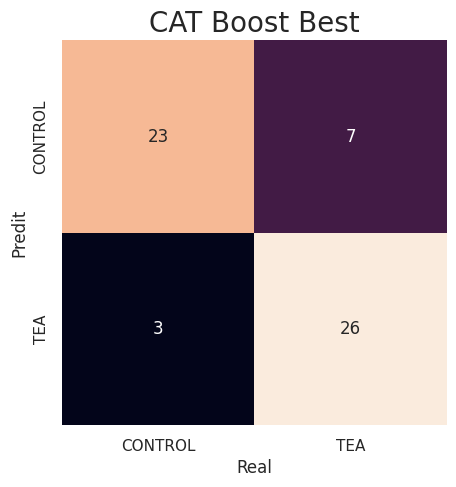

In [ ]:
# Plot Confusion Matrix
mat_CATBoost_Best= confusion_matrix(y_pred_CAT_Best, ytest)
names_CATBoost_Best = np.unique(y_pred_CAT_Best)
plt.figure(figsize=(5, 5))
plt.title("CAT Boost Best",fontsize=20)
sns.heatmap(mat_CATBoost_Best, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=names_CATBoost_Best, yticklabels=names_CATBoost_Best)
plt.xlabel('Real')
plt.ylabel('Predit')

In [ ]:
report_CATBoost_Best = classification_report(ytest, y_pred_CAT_Best)
print(report_CATBoost_Best)

              precision    recall  f1-score   support

     CONTROL       0.77      0.88      0.82        26
         TEA       0.90      0.79      0.84        33

    accuracy                           0.83        59
   macro avg       0.83      0.84      0.83        59
weighted avg       0.84      0.83      0.83        59



ROC-AUC: 0.8362470862470862


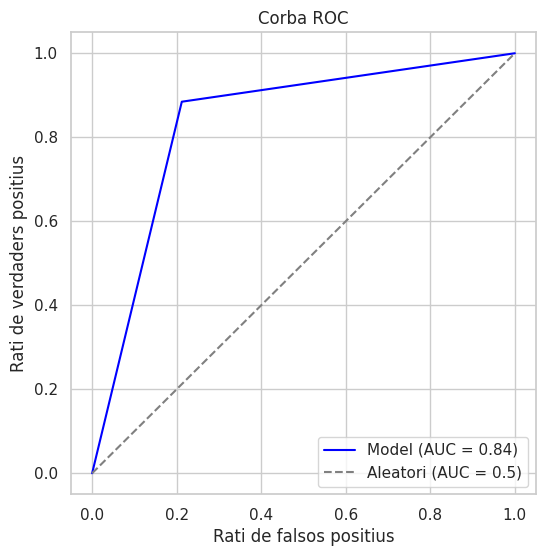

In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score
sns.set_style("whitegrid")
## Calcular corba ROC
# Define mapping dictionary
mapping = {"TEA": 0, "CONTROL": 1}
# Vectorized mapping
map_func = np.vectorize(mapping.get)
y_pred_np = map_func(y_pred_CAT_Best)

fpr, tpr, thresholds = roc_curve (ytest_np, y_pred_np)
# Calcular AUC
auc = roc_auc_score(ytest_np, y_pred_np)
print("ROC-AUC:", auc)
# Plot
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"Model (AUC = {auc:.2f})", color="blue")
plt.plot([0,1], [0,1], linestyle="--", color="gray", label="Aleatori (AUC = 0.5)")
plt.xlabel("Rati de falsos positius")
plt.ylabel("Rati de verdaders positius")
plt.title("Corba ROC")
plt.legend()
plt.show()

/tmp/ipython-input-1869739890.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


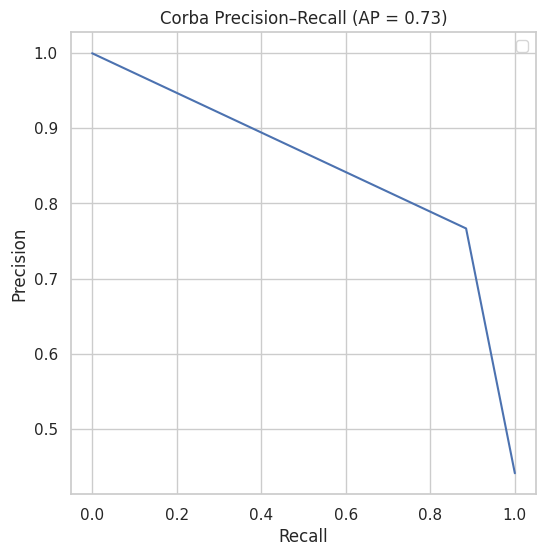

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(ytest_np, y_pred_np)
ap = average_precision_score(ytest_np, y_pred_np)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Corba Precision–Recall (AP = {ap:.2f})')
plt.legend()
plt.grid(True)
plt.show()


Imoprtància de les variables per catboost

/tmp/ipython-input-301485122.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(x= df_importance['feature'], y=df_importance['importance'],palette='Spectral')


                             feature  importance
10                     3rd ventricle    9.992880
11                     4th ventricle    7.079236
28                 right hippocampus    5.870471
26                     right putamen    5.147961
25                     right caudate    4.707651
23           right cerebellum cortex    4.256215
4       left cerebellum white matter    4.153418
15                               csf    3.729377
33                               SEX    3.531508
19             right cerebral cortex    3.447073
30              right accumbens area    3.397391
2             left lateral ventricle    3.141132
12                        brain-stem    3.027781
18       right cerebral white matter    2.997813
22     right cerebellum white matter    2.950640
17                   left ventral DC    2.927105
5             left cerebellum cortex    2.871825
7                       left caudate    2.580171
0         left cerebral white matter    2.561935
3    left inferior l

Text(0.5, 1.0, 'Importància regions per CatBoost')

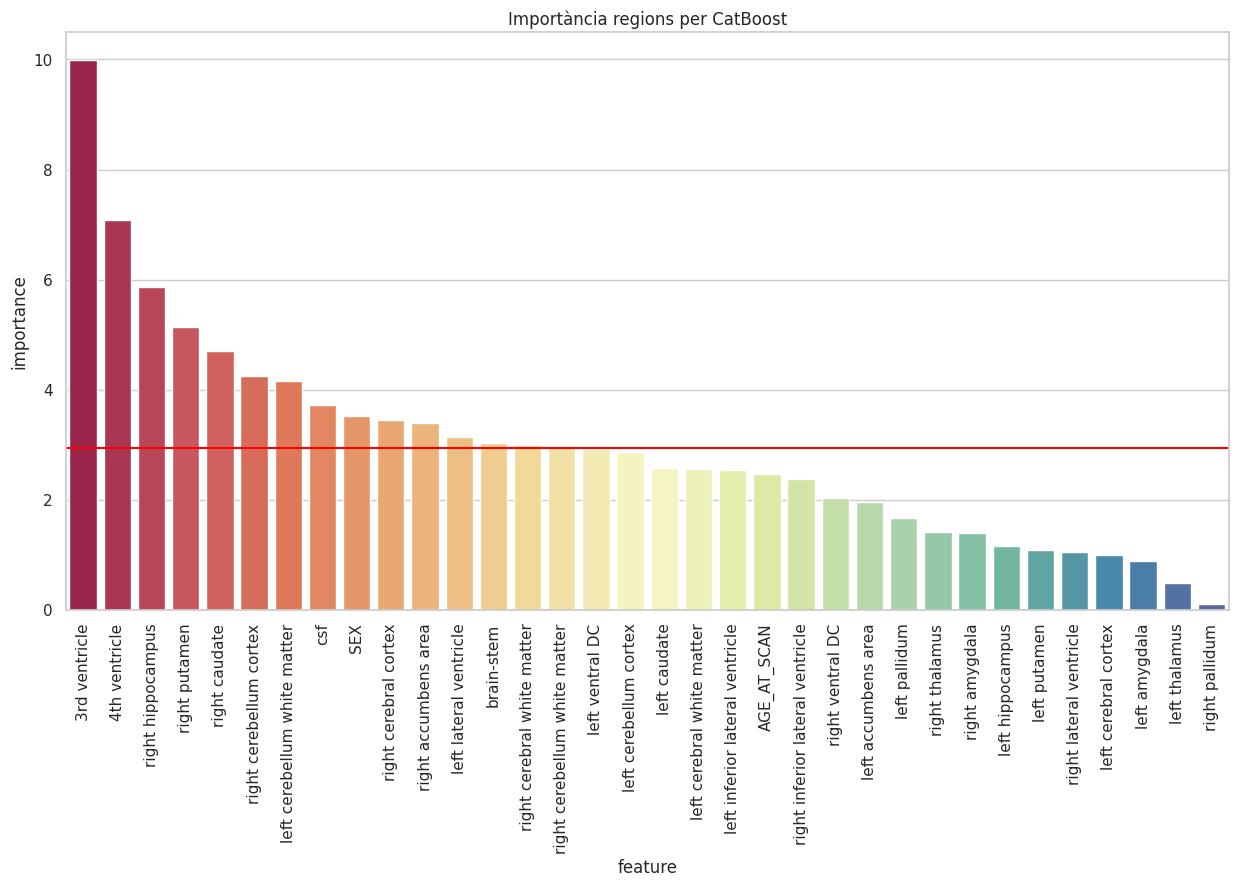

In [ ]:
from catboost import Pool

importances = cat_model_Best.get_feature_importance()
feature_names = xtrain.columns

df_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print(df_importance)

fig, axis = plt.subplots(figsize = (15,7.5))
plot = sns.barplot(x= df_importance['feature'], y=df_importance['importance'],palette='Spectral')
plot.axhline(df_importance['importance'].mean(), color='red')
#plot.set_xticks(np.arange(len(df_importance['feature'])))
axis.tick_params(axis='x', labelrotation=90)
#plot.set_xticks(rotation = 90)
plot.set_title("Importància regions per CatBoost")

# Resum rendiments

In [ ]:
noms = ["CATBoost Best"]
predictions = [y_pred_CAT_Best]

macro_avg_f1 = []
macro_weighted_f1 = []

accuracy = []
TEA = []
CONTROL = []


i = 0
for p in predictions:
    # Generate classification report
    class_report = classification_report(ytest, p, output_dict=True)
    TEA.append(class_report['TEA']['f1-score'])
    CONTROL.append(class_report['CONTROL']['f1-score'])

    # Append to list
    macro_avg_f1.append(class_report['macro avg']['f1-score'] )
    macro_weighted_f1.append(class_report['weighted avg']['f1-score'] )

    accuracy.append(class_report['accuracy'])

    i += 1

metriques = {'Models':noms, 'Precisió':accuracy, 'f1 TEA':TEA,
             'f1 Control':CONTROL,
             'Precisió avg':macro_avg_f1,
             'Precisió weighted':macro_weighted_f1}

df_metriques = pd.DataFrame(metriques)

#taula resum
display(df_metriques)

,Models,Precisió,f1 TEA,f1 Control,Precisió avg,Precisió weighted
0,CATBoost Best,0.830508,0.83871,0.821429,0.830069,0.831094
